# Week4 授業前課題1 アヤメを分類しよう

## 1.この課題の目的
- 教師あり学習（分類問題）の概観を知る
- scikit-laernを使い分類を行えるようにする
- 手法の簡単な比較をする

## 2.アヤメの分類
Week3で使用したirisデータセットを使い、分類問題を解く練習をします。

irisデータセットはカナダのガスペ半島のある牧草地で同じ日に採取された以下の3種類のアヤメ、合計150本のデータでした。

- [Iris setosa - Wikipedia](https://en.wikipedia.org/wiki/Iris_setosa)
- [Iris virgicolor - Wikipedia](https://en.wikipedia.org/wiki/Iris_versicolor)
- [Iris virginica - Wikipedia](https://en.wikipedia.org/wiki/Iris_virginica)

4種類の特徴量（説明変数）からアヤメの種類を推測する問題が設定できます。アヤメの種類を 分類 するので、こういったものを分類問題と呼びます。

### 今回使う手法の一覧
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

## 3.分類問題の流れ
まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。

この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。

### 練習のための準備
練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題1】練習のために特徴量とカテゴリを選択
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

- virgicolorとvirginica
- sepal_lengthとpetal_length

#### 実際の問題では？
実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
import matplotlib.patches as mpatches
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

In [2]:
iris_dataset = load_iris() # データセットの取得

X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"]) # 説明変数をXに格納
y = pd.DataFrame(iris_dataset.target, columns=["Species"]) # 目的変数をyに格納
df = pd.concat([X, y], axis=1) # X,yを結合
df = pd.DataFrame(df.loc[:, ["sepal_length", "petal_length", "Species"]].query('Species!=0')) # データフレームから2つの説明変数と2つの目的変数の分を抜き出す
display(df.head())

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1


＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題2】データの分析
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。

ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

#### 実際の問題では？

このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。

今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

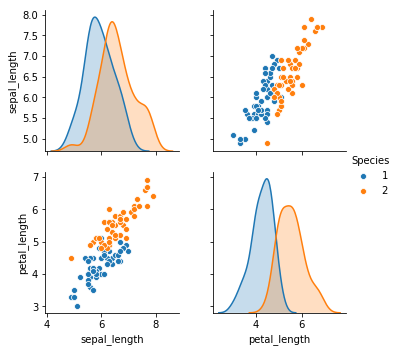

In [3]:
# 散布図行列を描画
sns.pairplot(df, hue='Species', vars=["sepal_length", "petal_length"])

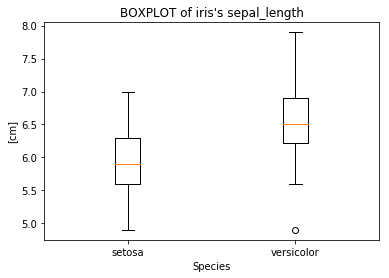

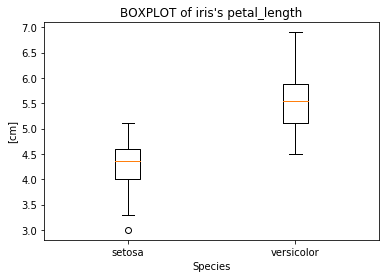

In [4]:
# 箱ひげ図を描画

# 特徴量を一つずつ選び、箱ひげ図を使ってラベルごとのデータの分布を可視化する
features = ["sepal_length", "petal_length"]

for feature in features:
    plt.boxplot([df[df["Species"]==1][feature], df[df["Species"]==2][feature]])
    plt.xticks([1, 2], iris_dataset.target_names)
    plt.title("BOXPLOT of iris's {}".format(feature))
    plt.ylabel('[cm]')
    plt.xlabel('Species')
    plt.show()

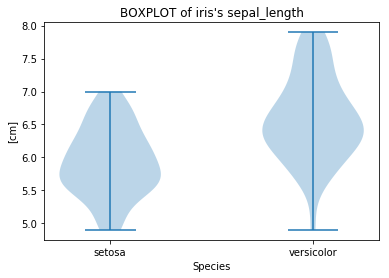

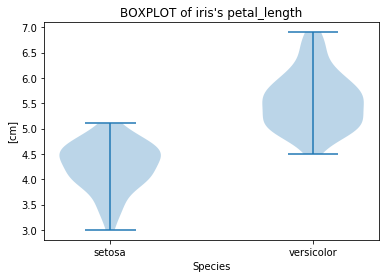

In [5]:
# バイオリン図を描画

for feature in features:
    plt.violinplot([df[df["Species"]==1][feature], df[df["Species"]==2][feature]])
    plt.xticks([1, 2], iris_dataset.target_names)
    plt.title("BOXPLOT of iris's {}".format(feature))
    plt.ylabel('[cm]')
    plt.xlabel('Species')
    plt.show()

### 前処理
データに加工をしていきます。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題3】前処理・学習用データと検証用データの分割
前処理の一貫として、学習用（train）データと検証用（validation）データの分割を行います。今回は学習用データ75%、検証用データ25%として分割してください。

scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。

[sklearn.model_selection.train_test_split — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

#### 注意点

データの分析まではPandasのDataFrame型を使用してきました。しかし、scikit-learnはNumPyのndarray型を想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

#### 分割する理由

分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを学習用データ、検証に使うデータが検証用データで、一般的に7対3から8対2程度の割合にします。

In [6]:
X = np.array(df.loc[:, ["sepal_length", "petal_length"]]) # Xに説明変数を格納
y = np.array(df.loc[:, "Species"]) # yに目的変数を格納

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # X, yを学習用、検証用に分割

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_train.ndim)
print(X_test.ndim)
print(y_train.ndim)
print(y_test.ndim)

print(X_train)
print(X_test)
print(y_train)
print(y_test)

(75, 2)
(25, 2)
(75,)
(25,)
2
2
1
1
[[6.7 4.4]
 [5.5 4.4]
 [6.3 5. ]
 [5.2 3.9]
 [7.7 6.7]
 [5.9 4.2]
 [6.2 4.3]
 [7.7 6.1]
 [6.  4.5]
 [6.8 5.9]
 [5.7 4.5]
 [6.5 5.5]
 [6.4 5.3]
 [6.  4.5]
 [5.6 4.5]
 [5.7 4.1]
 [5.4 4.5]
 [4.9 3.3]
 [6.7 5.2]
 [6.7 5. ]
 [5.6 3.9]
 [7.9 6.4]
 [6.6 4.4]
 [6.8 5.5]
 [6.1 4.7]
 [6.4 4.3]
 [5.5 4. ]
 [5.8 4.1]
 [5.6 4.1]
 [6.6 4.6]
 [6.4 5.6]
 [6.3 4.7]
 [5.8 5.1]
 [6.7 4.7]
 [6.9 5.4]
 [4.9 4.5]
 [5.9 5.1]
 [6.5 5.8]
 [5.  3.3]
 [6.3 6. ]
 [7.7 6.7]
 [5.7 4.2]
 [7.7 6.9]
 [6.4 5.3]
 [6.5 5.2]
 [7.2 5.8]
 [6.1 4.6]
 [6.7 5.8]
 [5.1 3. ]
 [6.2 5.4]
 [7.3 6.3]
 [7.2 6. ]
 [5.8 3.9]
 [6.7 5.7]
 [7.2 6.1]
 [5.7 5. ]
 [6.1 5.6]
 [6.3 4.4]
 [5.7 3.5]
 [6.4 4.5]
 [7.1 5.9]
 [6.1 4. ]
 [6.9 4.9]
 [6.1 4.7]
 [6.4 5.5]
 [6.9 5.1]
 [6.7 5.7]
 [6.3 5.6]
 [6.4 5.6]
 [5.9 4.8]
 [6.5 5.1]
 [5.6 4.9]
 [5.6 3.6]
 [5.8 5.1]
 [5.8 5.1]]
[[6.3 5.1]
 [6.3 5.6]
 [6.9 5.7]
 [5.7 4.2]
 [5.6 4.2]
 [5.5 4. ]
 [6.3 4.9]
 [7.4 6.1]
 [5.  3.5]
 [7.  4.7]
 [6.2 4.5]
 [5.5 3.8]
 [6.3 

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題4】前処理・標準化
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。

標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

[sklearn.preprocessing.StandardScaler — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

#### ＜注意点＞

標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証用データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。

#### ＜実際の問題での前処理は？＞

アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [7]:
scaler = StandardScaler()
scaler.fit(X_train) # Xの学習用データをfitさせる
X_train = scaler.transform(X_train) # Xの学習用データを標準化
X_test = scaler.transform(X_test) # Xの検証用データを標準化

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題5】学習と推定
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練用データです。

[sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

学習が終わった後、検証用データをpredictメソッドに入力し、推定を行ってください。

パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

In [8]:
neigh_5nn = KNeighborsClassifier() # k=5でインスタンス化
neigh_5nn.fit(X_train, y_train) # k=5で学習させる
y_pred_5nn = neigh_5nn.predict(X_test) # 検証用データの予測をおこなう


neigh_1nn = KNeighborsClassifier(n_neighbors=1) # k=1でインスタンス化
neigh_1nn.fit(X_train, y_train) # k=1で学習させる
y_pred_1nn = neigh_1nn.predict(X_test) # 検証用データの予測をおこなう


neigh_3nn = KNeighborsClassifier(n_neighbors=3) # k=3でインスタンス化
neigh_3nn.fit(X_train, y_train) # k=3で学習させる
y_pred_3nn = neigh_3nn.predict(X_test) # 検証用データの予測をおこなう

print("k=5 の場合での判別結果：{}".format(y_pred_5nn))
print("k=3 の場合での判別結果：{}".format(y_pred_3nn))
print("k=1 の場合での判別結果：{}".format(y_pred_1nn))
print("実際の判別表(模範解答)：{}".format(y_test))

k=5 の場合での判別結果：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2]
k=3 の場合での判別結果：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]
k=1 の場合での判別結果：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 2]
実際の判別表(模範解答)：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題6】評価
検証用データの特徴量を入力して得られた推定値と、検証用データの正解値の近さを計算し、学習したモデルを評価します。

2値分類を評価するための指標値には accuracy、precision、recall、f値 があります。それぞれの意味を理解するには、 混合行列（confusion matrix） を見ることになります。

- scikit-learnを使い4種類の指標を計算する
- 混合行列をscikit-learnを使い表示する
- 4種類の指標値の意味について簡単に調査して文章でまとめる

[sklearn.metrics.accuracy_score — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

[sklearn.metrics.precision_score — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)

[sklearn.metrics.recall_score — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)

[sklearn.metrics.f1_score — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

[sklearn.metrics.confusion_matrix — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

#### scikit-learnを使い4種類の指標を計算する

In [9]:
print("正解率：{:.3f}".format(accuracy_score(y_test, y_pred_5nn)))
print("適合率：{:.3f}".format(precision_score(y_test, y_pred_5nn)))
print("再現率：{:.3f}".format(recall_score(y_test, y_pred_5nn)))
print("F値：   {:.3f}".format(f1_score(y_test, y_pred_5nn)))

正解率：0.800
適合率：0.765
再現率：0.929
F値：   0.839


#### 混合行列をscikit-learnを使い表示する

In [10]:
confusion_matrix = confusion_matrix(y_test, y_pred_5nn)

print(confusion_matrix)
x = pd.DataFrame(confusion_matrix, index=["実際virgicolor", "実際virginica"], columns=["virgicolor と予測", "virginica と予測"])
x

[[13  1]
 [ 4  7]]


,virgicolor と予測,virginica と予測
実際virgicolor,13,1
実際virginica,4,7


##### 4種類の指標値の意味について簡単に調査して文章でまとめる
- accuracy(正解率)：すべてのサンプルのうち正解したサンプルの割合。$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$で求められる。  
- precision(適合率)：陽性と予測されたサンプルのうち正解したサンプルの割合。PPV（positive predictive value）とも呼ばれる。FP（偽陽性）が大きくなると適合率は小さくなる。偽陽性を避けたい（抑えたい）場合に指標として用いる。$precision = \frac{TP}{TP + FP}$で求められる。
- recall(再現率)：実際に陽性のサンプルのうち正解したサンプルの割合。sensitivityやhit rate, TPR（true positive rate, 真陽性率）などとも呼ばれる。FN（偽陰性）が大きくなると再現率は小さくなる。偽陰性を避けたい（抑えたい）場合に指標として用いる。$recall = \frac{TP}{TP + FN}$で求められる。
- F1値（F1-measure）：適合率と再現率の調和平均。 単純にF値（F-measure, F-score）と呼ばれることもある。$F1-measure = \frac{2 * precision * recall}{precision + recall} = \frac{2 * TP}{2 * TP + FP + FN}$

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題7】可視化
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練用データまたは検証用データを与えます。

```
import matplotlib.pyplot as plt   
from matplotlib.colors import ListedColormap   
import matplotlib.patches as mpatches   

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
```

3-nnの決定領域を表示した例が以下です。

<img src="capture5.png">

この例では訓練用データをプロットし、どのように学習したかを見ています。一方で、検証用データをプロットすればどういった特徴量のものが間違って分類されたかを見ることができます。

### 手法の改善
実際の問題では指標値や可視化を元に手法を改善していきますが、この課題では扱いません。

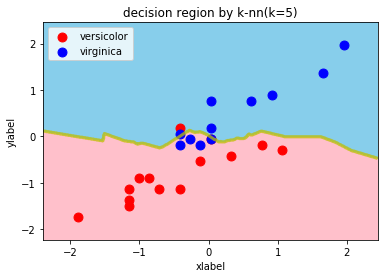

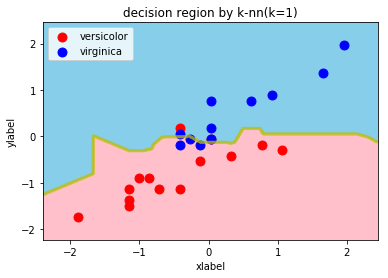

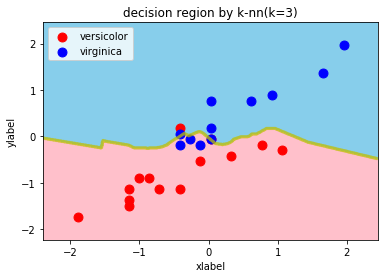

In [11]:
def decision_region(X, y, model, step=0.01, title='decision region',
                    xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
                                    np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
    
decision_region(X_test, y_test, neigh_5nn, title='decision region by k-nn(k=5)')
decision_region(X_test, y_test, neigh_1nn, title='decision region by k-nn(k=1)')
decision_region(X_test, y_test, neigh_3nn, title='decision region by k-nn(k=3)')

## 4.各手法の比較
他の手法も基本的な流れは同様です。他の手法でも学習から可視化までを行っていきます。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。

[sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)  
[sklearn.linear_model.LogisticRegression — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)  
[sklearn.svm.SVC — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)  
[sklearn.tree.DecisionTreeClassifier — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)  
[sklearn.ensemble.RandomForestClassifier — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### ＜実際の問題では？＞
ハイパーパラメータの調整は パラメータチューニング と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。

#### 最近傍法

予測：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2]
正解：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


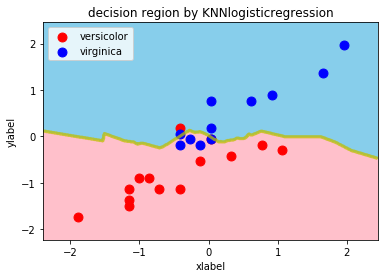

In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train) # データを学習させる
y_pred_knn = knn.predict(X_test) # 検証用データで推定させる
print("予測：{}".format(y_pred_knn))
print("正解：{}".format(y_test))

decision_region(X_test, y_test, knn, title='decision region by KNNlogisticregression') # グラフを描画

#### ロジスティック回帰

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


予測：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
正解：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


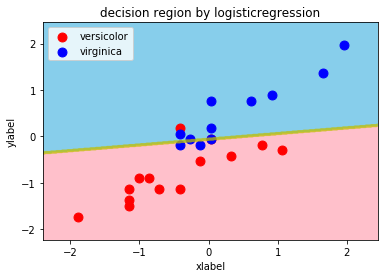

In [13]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train) # データを学習させる
y_pred_lr = lr.predict(X_test) # 検証用データで推定させる
print("予測：{}".format(y_pred_lr))
print("正解：{}".format(y_test))

decision_region(X_test, y_test, lr, title='decision region by logisticregression') # グラフよ描画

#### SVM

予測：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 2 1 1 2 1 1 1 2]
正解：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


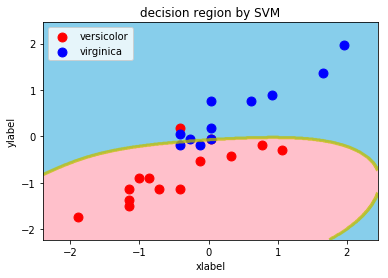

In [14]:
svm = SVC(random_state=0)
svm.fit(X_train, y_train) # データを学習させる

y_pred_svm = svm.predict(X_test) # 検証用データで推定させる
print("予測：{}".format(y_pred_svm)) 
print("正解：{}".format(y_test))

decision_region(X_test, y_test, svm, title='decision region by SVM') # グラフを描画

#### 決定木

予測：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
正解：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


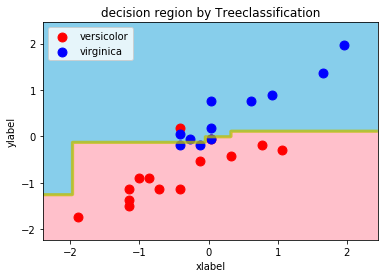

In [15]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train) # データを学習させる

y_pred_tree = tree.predict(X_test) # 検証用データで推定させる
print("予測：{}".format(y_pred_tree))
print("正解：{}".format(y_test))

decision_region(X_test, y_test, tree, title='decision region by Treeclassification') # グラフを描画 

#### ランダムフォレスト

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


予測：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
正解：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


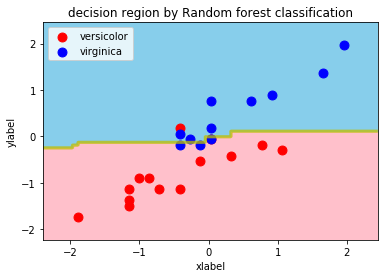

In [16]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train, y_train) # データを学習させる

y_pred_forest = random_forest.predict(X_test) # 検証用データで推定させる
print("予測：{}".format(y_pred_forest))
print("正解：{}".format(y_test))

decision_region(X_test, y_test, random_forest, title='decision region by Random forest classification') # グラフを描画

#### 4つの指標の一覧

In [17]:
# 指標を算出する関数
def get_index(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    index_list = [accuracy, precision, recall, f1]
    return index_list

knn_list = get_index(y_test, y_pred_knn)
lr_list = get_index(y_test, y_pred_lr)
svm_list = get_index(y_test, y_pred_svm)
tree_list = get_index(y_test, y_pred_tree)
forest_list = get_index(y_test, y_pred_forest)


df_4index_columns = ["accuracy", "precision", "recall", "f1"]
df_4index_index = ["最近傍法", "ロジスティック回帰", "SVM", "決定木", "ランダムフォレスト"]
df_4index = pd.DataFrame([knn_list, lr_list, svm_list, tree_list, forest_list], columns=df_4index_columns, index=df_4index_index)
display(df_4index)

,accuracy,precision,recall,f1
最近傍法,0.80,0.764706,0.928571,0.838710
ロジスティック回帰,0.84,0.812500,0.928571,0.866667
SVM,0.84,0.857143,0.857143,0.857143
決定木,0.84,0.812500,0.928571,0.866667
ランダムフォレスト,0.84,0.812500,0.928571,0.866667


#### 【考察】
- ロジスティック回帰は直線、SVMは楕円のような曲線で境界線を引いている。
- accuracyは最近傍法が他に比べ低く、他は同じ数値である。
- precisionも最近傍法が一番低く、SVMが一番高い数値である。他の3つは同じ数値になった。
- recallは逆にSVMが一番低い数値で、他の四つは同じ数値になった。
- f値は最近傍法が最も低く、ロジスティック回帰、決定木、ランダムフォレストが同じ数値で一番高くなっている。
- ロジスティック回帰、決定木、ランダムフォレストは4つの指標の値がそれぞれ同じ数値になっている。
- SVMはpresision、recall、f1値がすべて同じ値になっている。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題9】（アドバンス課題）標準化の有無の比較
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

In [18]:
iris_dataset = load_iris() # データセットの取得
X1 = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"]) # 説明変数をX1に格納
y1 = pd.DataFrame(iris_dataset.target, columns=["Species"]) # 目的変数をy1に格納
df1 = pd.concat([X1, y1], axis=1) # X1,y1を結合
df1 = pd.DataFrame(df1.loc[:, ["sepal_length", "petal_length", "Species"]].query('Species!=0')) # データフレームから2つの説明変数と2つの目的変数の分を抜き出す

X1 = np.array(df1.loc[:, ["sepal_length", "petal_length"]]) # X1に説明変数を格納
y1 = np.array(df1.loc[:, "Species"]) # y1に目的変数を格納

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42) # X1, y1を学習用、検証用に分割

print(X1_train.shape)
print(X1_test.shape)
print(y1_train.shape)
print(y1_test.shape)

(75, 2)
(25, 2)
(75,)
(25,)


#### 最近傍法

予測(標準化あり)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2]
予測(標準化なし)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2]
正解：　　　　　  [2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


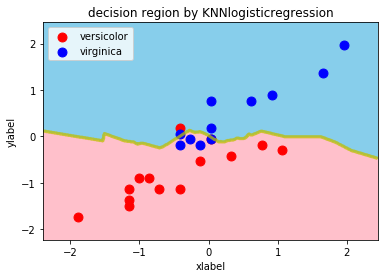

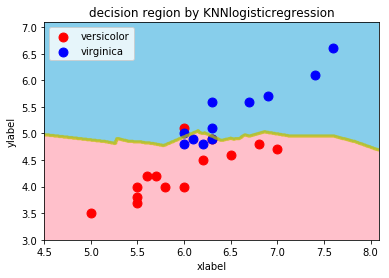

In [19]:
knn1 = KNeighborsClassifier()
knn1.fit(X1_train, y1_train)
y_pred_knn1 = knn1.predict(X1_test)
print("予測(標準化あり)：{}".format(y_pred_knn))
print("予測(標準化なし)：{}".format(y_pred_knn1))
print("正解：　　　　　  {}".format(y1_test))

decision_region(X_test, y_test, knn, title='decision region by KNNlogisticregression')
decision_region(X1_test, y1_test, knn1, title='decision region by KNNlogisticregression')

#### ロジスティック回帰

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


予測(標準化あり)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
予測(標準化なし)：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 2 1 1 2 2 1 1 2]
正解：            [2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


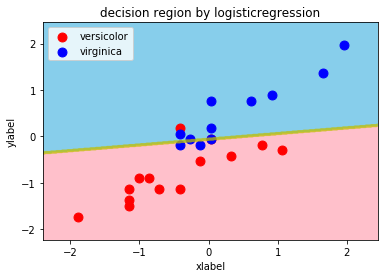

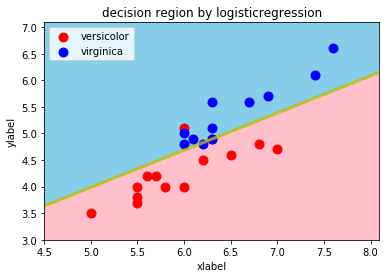

In [20]:
lr1 = LogisticRegression(random_state=0)
lr1.fit(X1_train, y1_train)
y_pred_lr1 = lr1.predict(X1_test)
print("予測(標準化あり)：{}".format(y_pred_lr))
print("予測(標準化なし)：{}".format(y_pred_lr1))
print("正解：            {}".format(y1_test))

decision_region(X_test, y_test, lr, title='decision region by logisticregression')
decision_region(X1_test, y1_test, lr1, title='decision region by logisticregression')

#### SVM

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


予測(標準化あり)：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 2 1 1 2 1 1 1 2]
予測(標準化なし)：[2 2 2 1 1 1 2 2 1 1 1 1 2 2 2 1 1 2 1 1 2 1 1 1 2]
正解            ：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


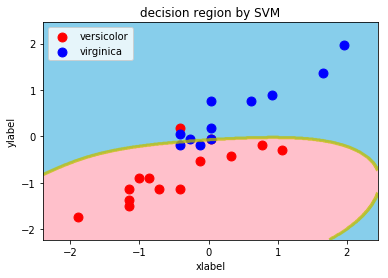

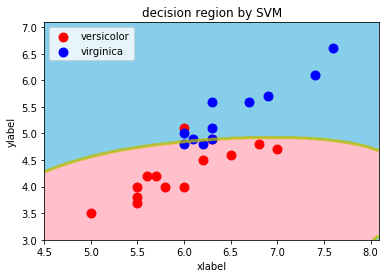

In [21]:
svm1 = SVC(random_state=0)
svm1.fit(X1_train, y1_train)

y_pred_svm1 = svm1.predict(X1_test)
print("予測(標準化あり)：{}".format(y_pred_svm))
print("予測(標準化なし)：{}".format(y_pred_svm1))
print("正解            ：{}".format(y1_test))

decision_region(X_test, y_test, svm, title='decision region by SVM')
decision_region(X1_test, y1_test, svm1, title='decision region by SVM')

#### 決定木

予測(標準化あり)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
予測(標準化なし)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
正解            ：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


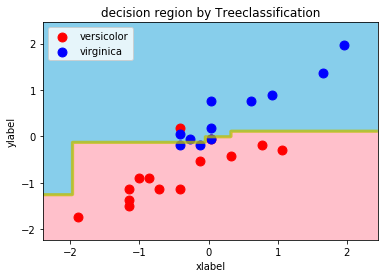

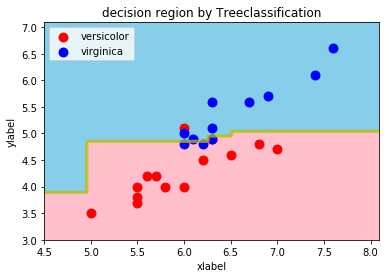

In [22]:
tree1 = DecisionTreeClassifier(random_state=0)
tree1.fit(X1_train, y1_train)

y_pred_tree1 = tree1.predict(X1_test)
print("予測(標準化あり)：{}".format(y_pred_tree))
print("予測(標準化なし)：{}".format(y_pred_tree1))
print("正解            ：{}".format(y1_test))

decision_region(X_test, y_test, tree, title='decision region by Treeclassification')
decision_region(X1_test, y1_test, tree1, title='decision region by Treeclassification')

#### ランダムフォレスト

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


予測(標準化あり)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
予測(標準化なし)：[2 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 2]
正解            ：[2 2 2 1 1 1 1 2 1 1 1 1 2 1 2 1 2 2 1 1 2 2 1 1 2]


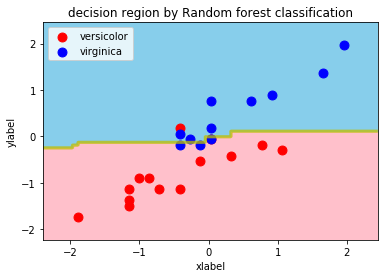

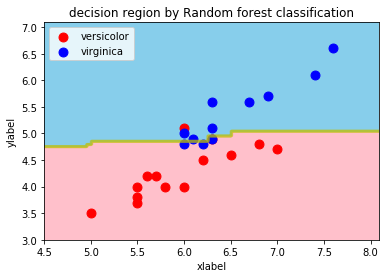

In [23]:
random_forest1 = RandomForestClassifier(random_state=0)
random_forest1.fit(X1_train, y1_train)

y_pred_forest1 = random_forest1.predict(X1_test)
print("予測(標準化あり)：{}".format(y_pred_forest))
print("予測(標準化なし)：{}".format(y_pred_forest1))
print("正解            ：{}".format(y1_test))

decision_region(X_test, y_test, random_forest, title='decision region by Random forest classification')
decision_region(X1_test, y1_test, random_forest1, title='decision region by Random forest classification')

#### 四つの指標の比較

In [24]:
knn_list1 = get_index(y1_test, y_pred_knn1)
lr_list1 = get_index(y1_test, y_pred_lr1)
svm_list1 = get_index(y1_test, y_pred_svm1)
tree_list1 = get_index(y1_test, y_pred_tree1)
forest_list1 = get_index(y1_test, y_pred_forest1)


df_4index_columns = ["accuracy", "precision", "recall", "f1"]
df_4index_index = ["最近傍法(標準化あり)", "ロジスティック回帰(標準化あり)", "SVM(標準化あり)",
                   "決定木(標準化あり)", "ランダムフォレスト(標準化あり)"]
df_4index_index1 = ["最近傍法(標準化なし)", "ロジスティック回帰(標準化なし)", "SVM(標準化なし)",
                    "決定木(標準化なし)", "ランダムフォレスト(標準化なし)"]
df_4index = pd.DataFrame([knn_list, lr_list, svm_list, tree_list, forest_list], columns=df_4index_columns, index=df_4index_index)
df_4index1 = pd.DataFrame([knn_list1, lr_list1, svm_list1, tree_list1, forest_list1], columns=df_4index_columns, index=df_4index_index1)
display(df_4index) # 標準化ありの場合の指標のリストを表示
display(df_4index1) # 標準化なしの場合の指標のリストを表示

,accuracy,precision,recall,f1
最近傍法(標準化あり),0.80,0.764706,0.928571,0.838710
ロジスティック回帰(標準化あり),0.84,0.812500,0.928571,0.866667
SVM(標準化あり),0.84,0.857143,0.857143,0.857143
決定木(標準化あり),0.84,0.812500,0.928571,0.866667
ランダムフォレスト(標準化あり),0.84,0.812500,0.928571,0.866667


,accuracy,precision,recall,f1
最近傍法(標準化なし),0.80,0.764706,0.928571,0.838710
ロジスティック回帰(標準化なし),0.88,0.923077,0.857143,0.888889
SVM(標準化なし),0.84,0.857143,0.857143,0.857143
決定木(標準化なし),0.84,0.812500,0.928571,0.866667
ランダムフォレスト(標準化なし),0.84,0.812500,0.928571,0.866667


### 【考察】
- 最近傍法、決定木、ランダムフォレストの手法では標準化の有無によって判定の差異はなく従って4つの指標も変わらない。また、境界線も明らかな違いは見られなかった。
- ロジスティック回帰では境界線の引き方が変わっており、標準化をしないと直線の傾きが大きくなっている。それによって判定結果も一部異なっており、指標ではrecall以外の数値は標準化しない方がよくなっている。
- SVMでも境界線の引き方が変化しているが、中央値付近ではそこまで差異はないため判定結果に違いはなかった。したがって指標も標準化有無によって変わらなかったが、中央力離れたデータがあった場合は判定結果も変わる可能性があると思われる。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題10】（アドバンス課題）全ての目的変数を使用して精度が高い手法
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。

#### ＜多値になることでの変更点＞
指標値precision、recall、f値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。

決定領域を可視化する前述の関数は適切に書き換える必要があります。  
以下が出力例です。

<img src="capture6.png">

ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは自動的に判断して処理が行われるため変更は必要ありません。

In [25]:
X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"]) # 説明変数をXに格納
y = pd.DataFrame(iris_dataset.target, columns=["Species"]) # 目的変数をyに格納
df = pd.concat([X, y], axis=1) # X,yを結合
df = pd.DataFrame(df.loc[:, ["sepal_length", "petal_length", "Species"]]) # データフレームから2つの説明変数と2つの目的変数の分を抜き出す

X = np.array(df.loc[:, ["sepal_length", "petal_length"]]) # Xに説明変数を格納
X = np.array(X) # Xに説明変数を格納
y = np.array(y.loc[:, "Species"]) # yに目的変数を格納

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # X, yを学習用、検証用に分割

scaler = StandardScaler()
scaler.fit(X_train) # Xの学習用データをfitさせる
X_train = scaler.transform(X_train) # Xの学習用データを標準化
X_test = scaler.transform(X_test) # Xの検証用データを標準化

In [26]:
# グラフを描画する関数の作成
def decision_region(X, y, model, step=0.01, title='decision region',
                    xlabel='xlabel', ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['greenyellow', 'pink', 'skyblue']
    n_class = 3

    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step),
                                   np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    
    mesh = np.c_[np.ravel(mesh_f0), np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1],
                    s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

#### 最近傍法

予測：[1 0 2 1 1 0 1 1 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
正解：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


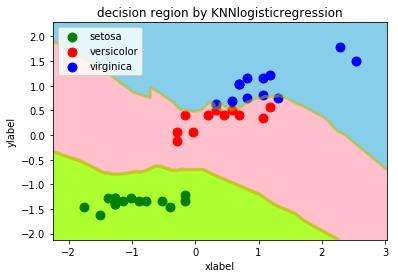

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("予測：{}".format(y_pred_knn))
print("正解：{}".format(y_test))

decision_region(X_test, y_test, knn, title='decision region by KNNlogisticregression')

#### ロジスティック回帰

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


予測：[2 0 2 1 2 0 1 2 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 2 0 0 2 2
 0]
正解：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


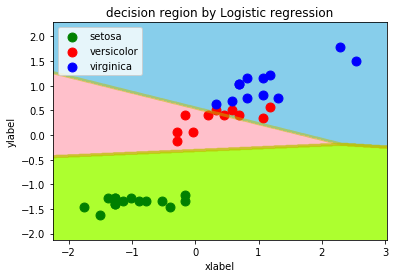

In [28]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("予測：{}".format(y_pred_lr))
print("正解：{}".format(y_test))
decision_region(X_test, y_test, lr, title='decision region by Logistic regression')

#### SVM

予測：[2 0 2 1 2 0 1 2 1 1 2 0 0 0 0 2 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 2 0 0 2 2
 0]
正解：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


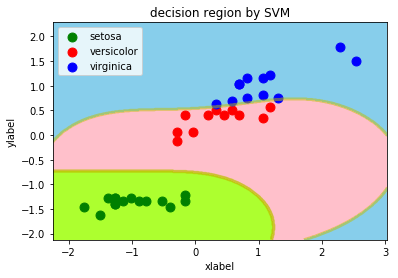

In [29]:
svm = SVC(random_state=0)
svm.fit(X_train, y_train)
y_pred_svm = lr.predict(X_test)
print("予測：{}".format(y_pred_svm))
print("正解：{}".format(y_test))
decision_region(X_test, y_test, svm, title='decision region by SVM')

#### 決定木

予測：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
正解：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


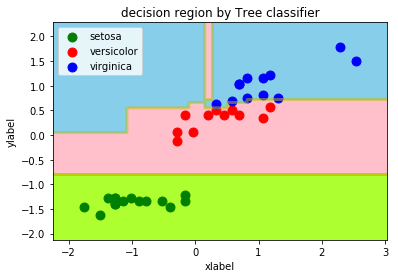

In [30]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
print("予測：{}".format(y_pred_tree))
print("正解：{}".format(y_test))
decision_region(X_test, y_test, tree, title='decision region by Tree classifier')

#### ランダムフォレスト

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


予測：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
正解：[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


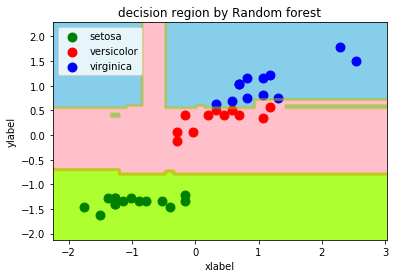

In [31]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(X_train, y_train)
y_pred_forest = random_forest.predict(X_test)
print("予測：{}".format(y_pred_forest))
print("正解：{}".format(y_test))
decision_region(X_test, y_test, random_forest, title='decision region by Random forest')

In [32]:
def get_index(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    index_list = [accuracy, precision, recall, f1]
    return index_list

knn_list = get_index(y_test, y_pred_knn)
lr_list = get_index(y_test, y_pred_lr)
svm_list = get_index(y_test, y_pred_svm)
tree_list = get_index(y_test, y_pred_tree)
forest_list = get_index(y_test, y_pred_forest)


df_4index_columns = ["accuracy", "precision", "recall", "f1"]
df_4index_index = ["最近傍法", "ロジスティック回帰", "SVM", "決定木", "ランダムフォレスト"]
df_4index = pd.DataFrame([knn_list, lr_list, svm_list, tree_list, forest_list], columns=df_4index_columns, index=df_4index_index)
display(df_4index)

,accuracy,precision,recall,f1
最近傍法,0.947368,0.947368,0.947368,0.947368
ロジスティック回帰,0.868421,0.868421,0.868421,0.868421
SVM,0.868421,0.868421,0.868421,0.868421
決定木,1.000000,1.000000,1.000000,1.000000
ランダムフォレスト,1.000000,1.000000,1.000000,1.000000


### 【考察】
- 決定木、ランダムフォレストの手法は正解率が100%という結果になり、三値分類でも精度が高い結果となった。